In [2]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [3]:
for no in ['A','B','C','D']:
    tracks[no] = tracks[no][['date', 'キロ程', '高低左']]

In [34]:
%matplotlib inline

In [4]:
import datetime
from tqdm import tqdm
import random
import sys

In [5]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [6]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [7]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                                                            df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [9]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [10]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [11]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [68]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [15]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [7]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [36]:
summarys = {}
for no in ['A','B','C','D']:
#     summarys[no] = pd.read_csv("summary12_" + no + "_lgbm.csv", index_col=0)
    summarys[no] = pd.read_csv("summary12_" + no + ".csv", index_col=0)

In [37]:
import pandas_profiling as pdp

In [38]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == -100, '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

# LightGBM

In [39]:
summarys['A']

,路線,キロ程,傾き,切片,標本標準偏差,測定回数,データ数
0,A,10000,-0.003067,0.0,3.795202,261,76
1,A,10001,-0.002222,0.0,3.165688,260,105
2,A,10002,-0.003625,0.0,3.497406,259,54
3,A,10003,0.000199,0.0,4.083893,259,55
4,A,10004,0.002985,0.0,3.805207,261,57
5,A,10005,0.000586,0.0,2.261965,261,71
6,A,10006,-0.000215,0.0,2.588153,257,56
7,A,10007,0.003765,0.0,4.033433,255,83
8,A,10008,0.001148,0.0,4.599720,251,101
9,A,10009,-0.001019,0.0,3.482811,251,76


In [119]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)
#     train[f'lag{-i-1}'] = train['slope'].shift(-i-1)

In [120]:
train

,slope,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
0,-0.003067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.002222,-0.003067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.003625,-0.002222,-0.003067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000199,-0.003625,-0.002222,-0.003067,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.002985,0.000199,-0.003625,-0.002222,-0.003067,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000586,0.002985,0.000199,-0.003625,-0.002222,-0.003067,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.000215,0.000586,0.002985,0.000199,-0.003625,-0.002222,-0.003067,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003625,-0.002222,-0.003067,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.001148,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003625,-0.002222,-0.003067,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.001019,0.001148,0.003765,-0.000215,0.000586,0.002985,0.000199,-0.003625,-0.002222,-0.003067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07770793475906908

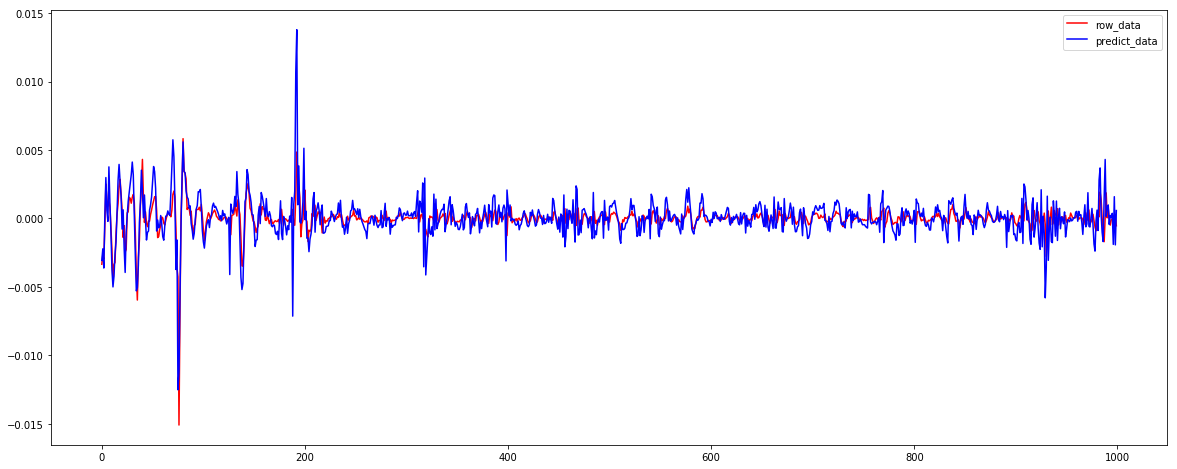

In [122]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07770793475906908

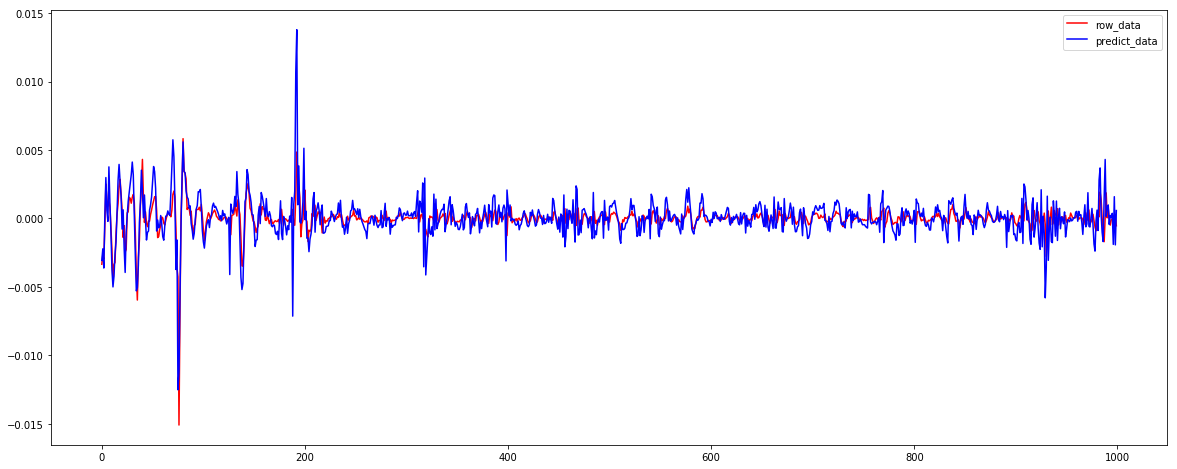

In [43]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.056416308099150464

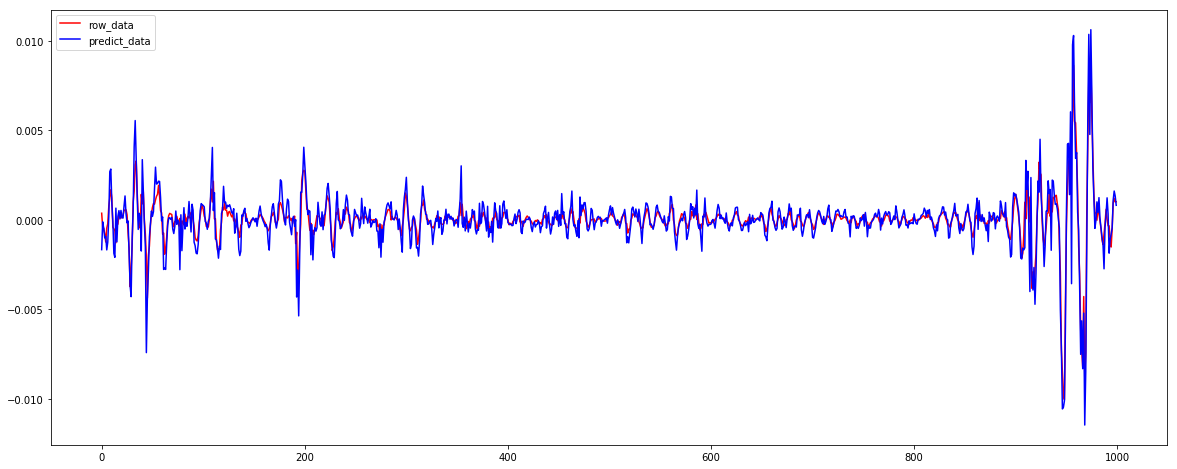

In [55]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07770793475906908

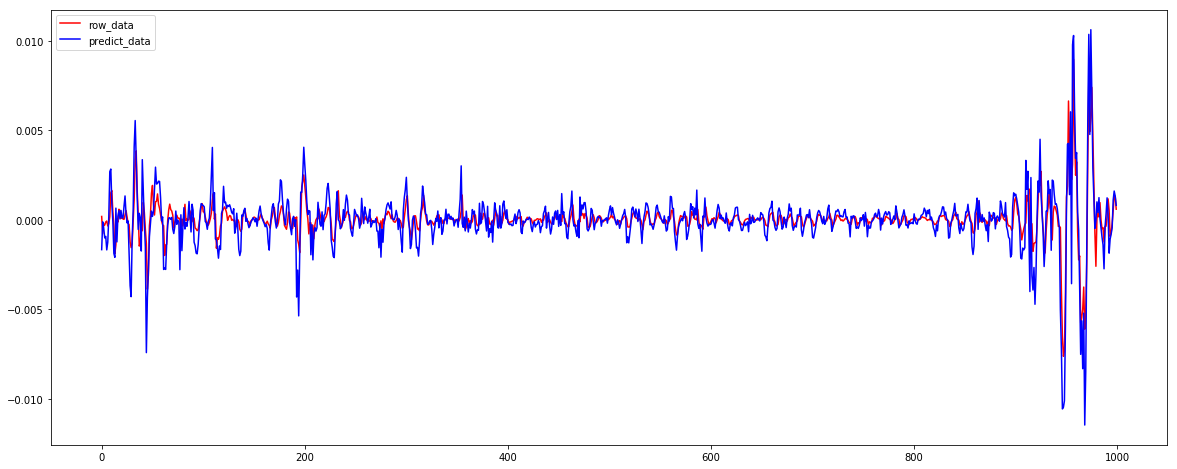

In [44]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


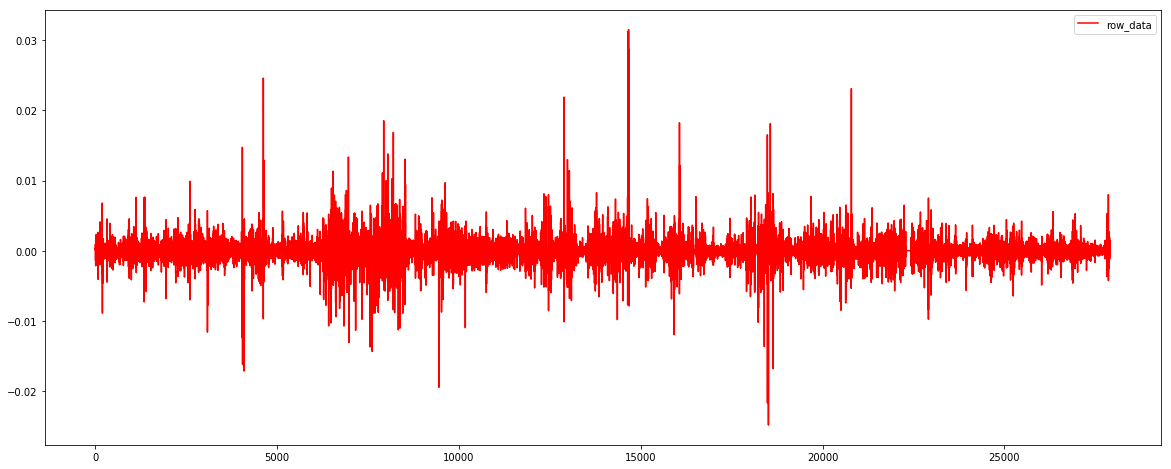

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


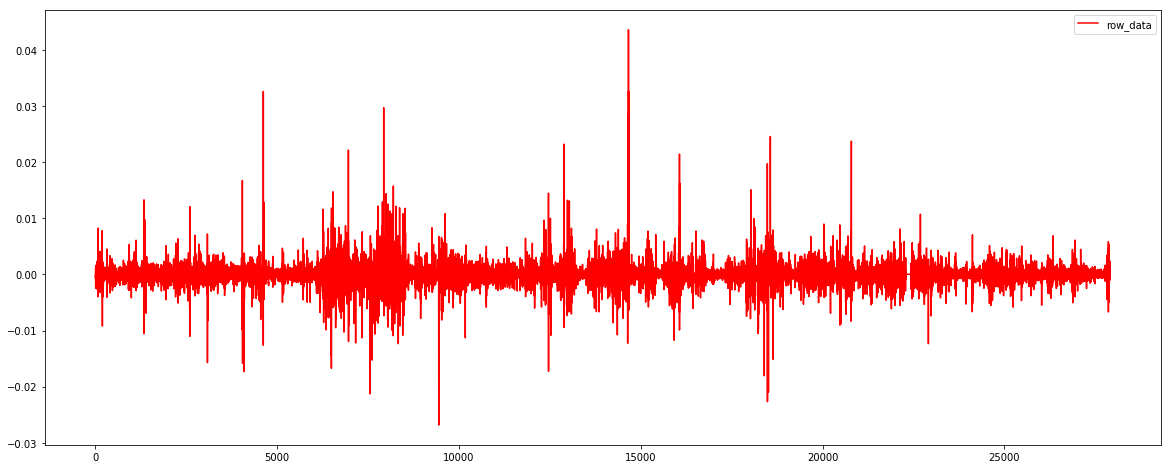

In [45]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [57]:
summarys['D']

,路線,キロ程,傾き,切片,標本標準偏差,測定回数,データ数
0,D,10000,-0.001744,0.0,0.286509,211,54
1,D,10001,0.003181,0.0,0.356374,211,44
2,D,10002,0.002455,0.0,0.330879,212,47
3,D,10003,0.001804,0.0,0.193736,213,36
4,D,10004,0.003191,0.0,0.361624,212,40
5,D,10005,-0.000062,0.0,0.528602,213,42
6,D,10006,-0.001089,0.0,0.404685,213,34
7,D,10007,0.002328,0.0,0.409819,213,41
8,D,10008,0.000415,0.0,0.872255,214,43
9,D,10009,-0.001869,0.0,1.043773,213,70


In [113]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})
# for i in range(1):
#     train[f'lag{i+1}'] = train['slope'].shift(i+1)
# train['dif'] = train['slope'] - train['lag1']
# lagdif = train['dif'].shift(1)
# train['difdif'] = train['dif'] - lagdif

lag = train['slope'].shift(1)
train['dif'] = train['slope'] - lag
lagdif = train['dif'].shift(1)
train['difdif'] = train['dif'] - lagdif

#     train[f'lag{-i-1}'] = train['slope'].shift(-i-1)

In [114]:
train

,slope,dif,difdif
0,-0.001744,NaN,NaN
1,0.003181,0.004925,NaN
2,0.002455,-0.000726,-0.005651
3,0.001804,-0.000651,0.000075
4,0.003191,0.001387,0.002038
5,-0.000062,-0.003253,-0.004640
6,-0.001089,-0.001027,0.002225
7,0.002328,0.003417,0.004444
8,0.000415,-0.001913,-0.005329
9,-0.001869,-0.002284,-0.000371


In [115]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.20917399020830815

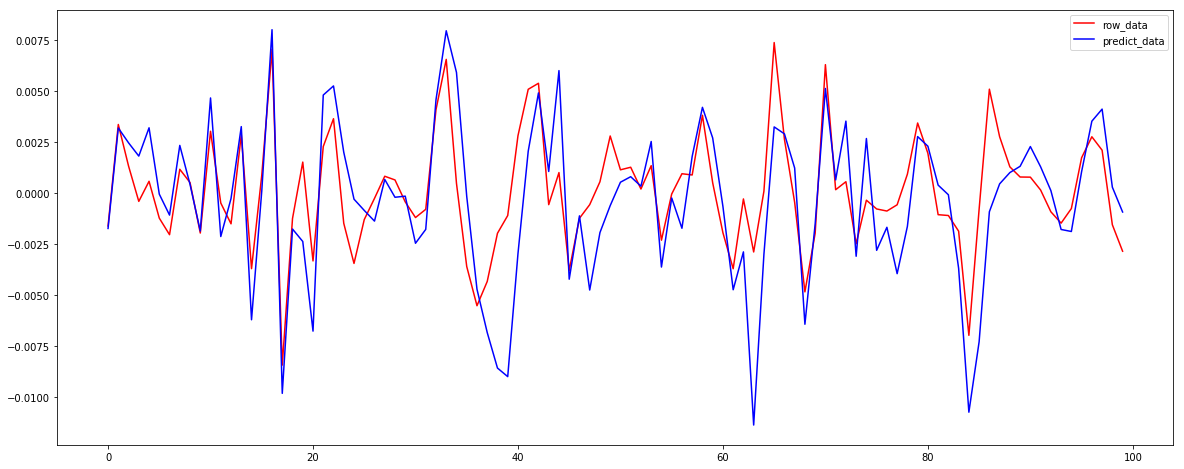

In [116]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:100])), train_pred[:100], color="r", label="row_data")
plt.plot(range(len(y_train[:100])), y_train[:100], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.20917399020830815

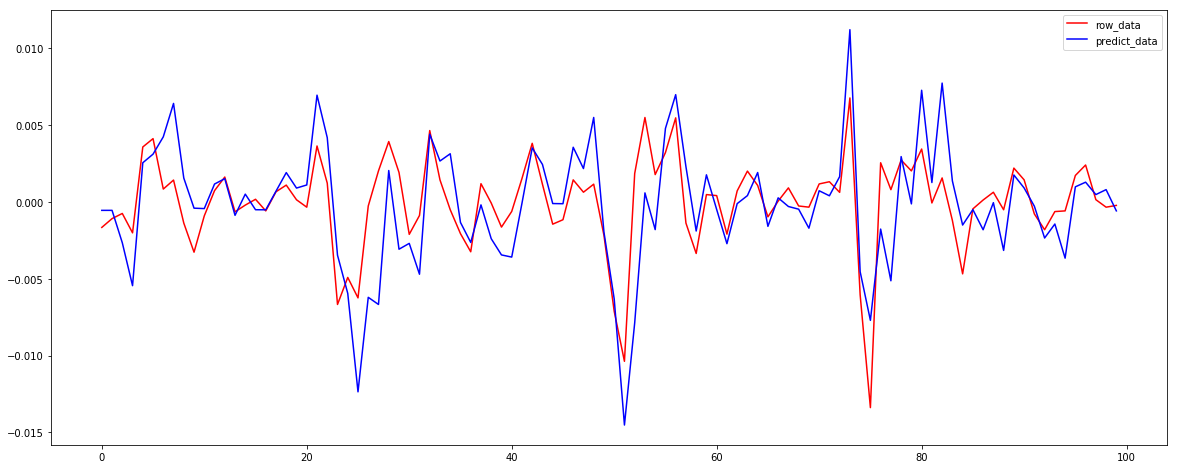

In [117]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[300:400])), train_pred[300:400], color="r", label="row_data")
plt.plot(range(len(y_train[300:400])), y_train[300:400], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.20917399020830815

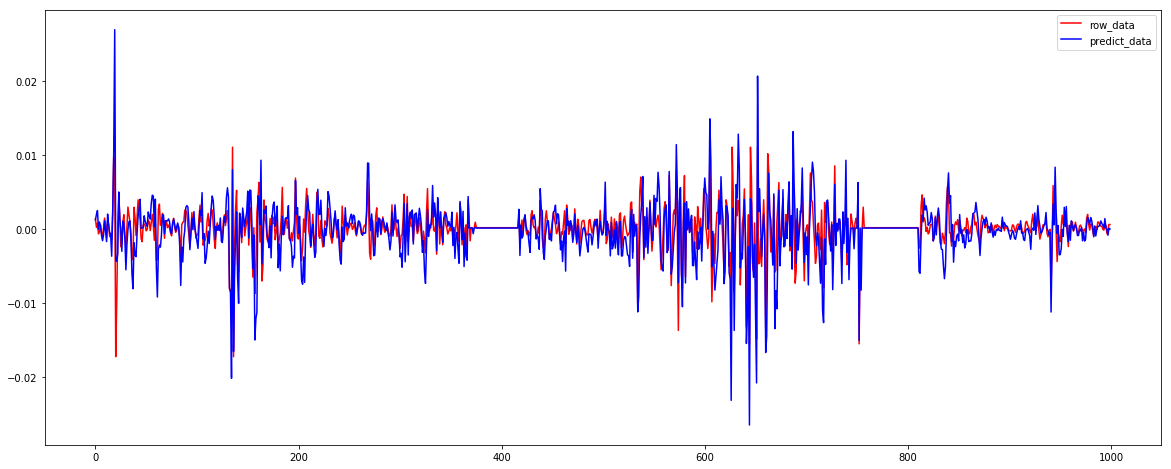

In [118]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.12495381943502061

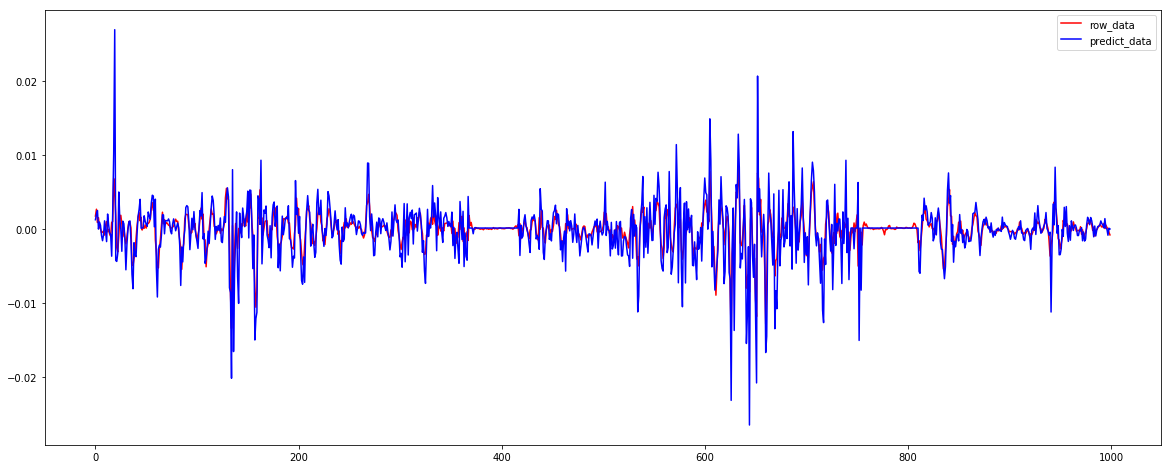

In [66]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.16450432668837123

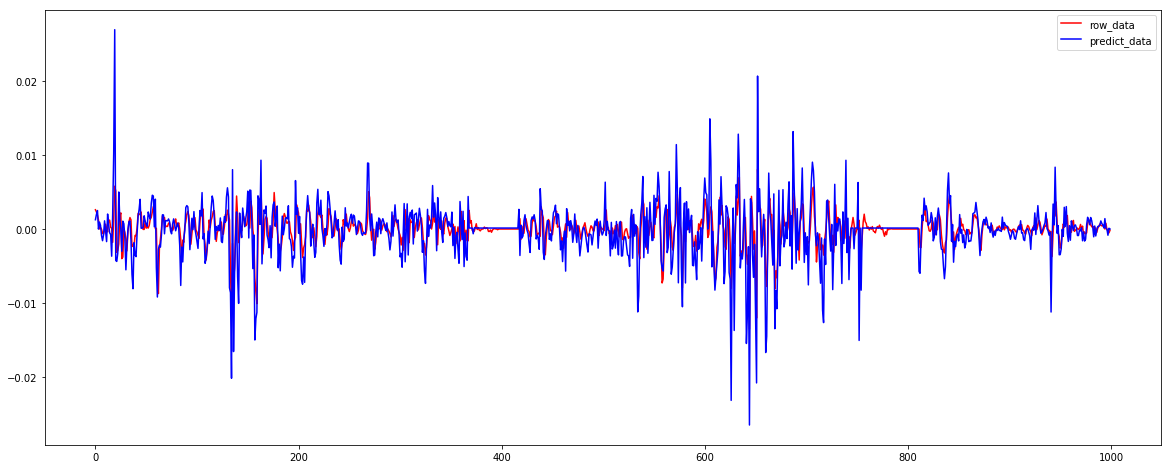

In [50]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

In [34]:
for no in ['A', 'B', 'C', 'D']:
    train = summarys[no]['傾き'].values
    train = pd.DataFrame({'slope': train})
    for i in range(30):
        train[f'lag{i+1}'] = train['slope'].shift(i+1)

    X_train = train.drop(['slope'], axis=1).values
    y_train = train['slope'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary12_{no}_lgbm.csv')

In [36]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[no]
    summary = summary.dropna()

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no

    kilos = summary['キロ程'].values
    inds = kilos.astype(int) - 10000

    sub.loc[inds, '傾き'] = summary['傾き'].values
    sub.loc[inds, '切片'] = summary['切片'].values
    
    submit = pd.concat([submit, sub], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 2.11 s, sys: 161 ms, total: 2.27 s
Wall time: 2.67 s


In [37]:
pdp.ProfileReport(submit)

Number of variables,4
Number of observations,120812
Total Missing (%),0.6%
Total size in memory,3.7 MiB
Average record size in memory,32.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [38]:
p = []
last_median_day = 30
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    for i in range(91):
        day = tmp['切片'].values + tmp['傾き'].values*(i+last_median_day//2)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [39]:
submision.max()

0    17.77
dtype: float64

In [40]:
submision.min()

0   -17.29
dtype: float64

In [41]:
submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [42]:
submision.max()

0    16.0
dtype: float64

In [43]:
submision.min()

0   -16.0
dtype: float64

In [44]:
submision

,0
0,0.52
1,2.64
2,4.96
3,5.87
4,5.07
5,1.67
6,-3.09
7,-7.22
8,-8.84
9,-7.42


Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

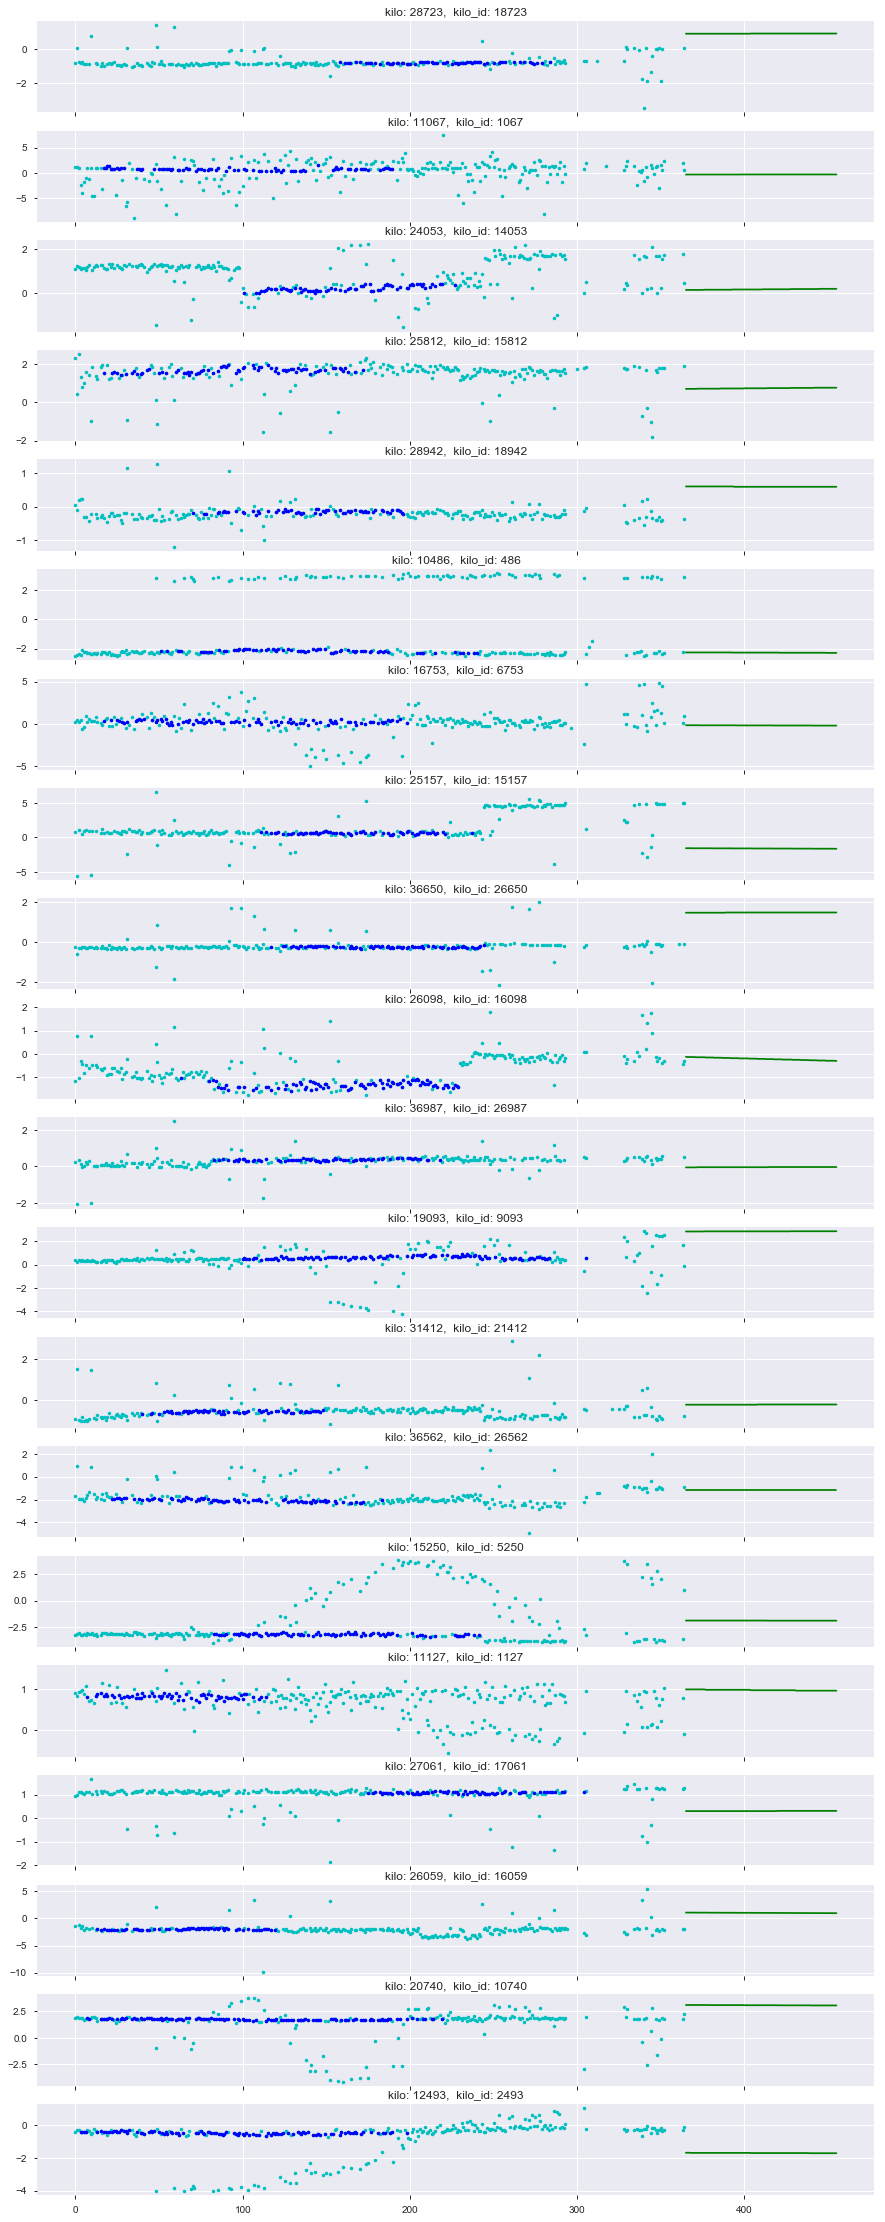

In [46]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

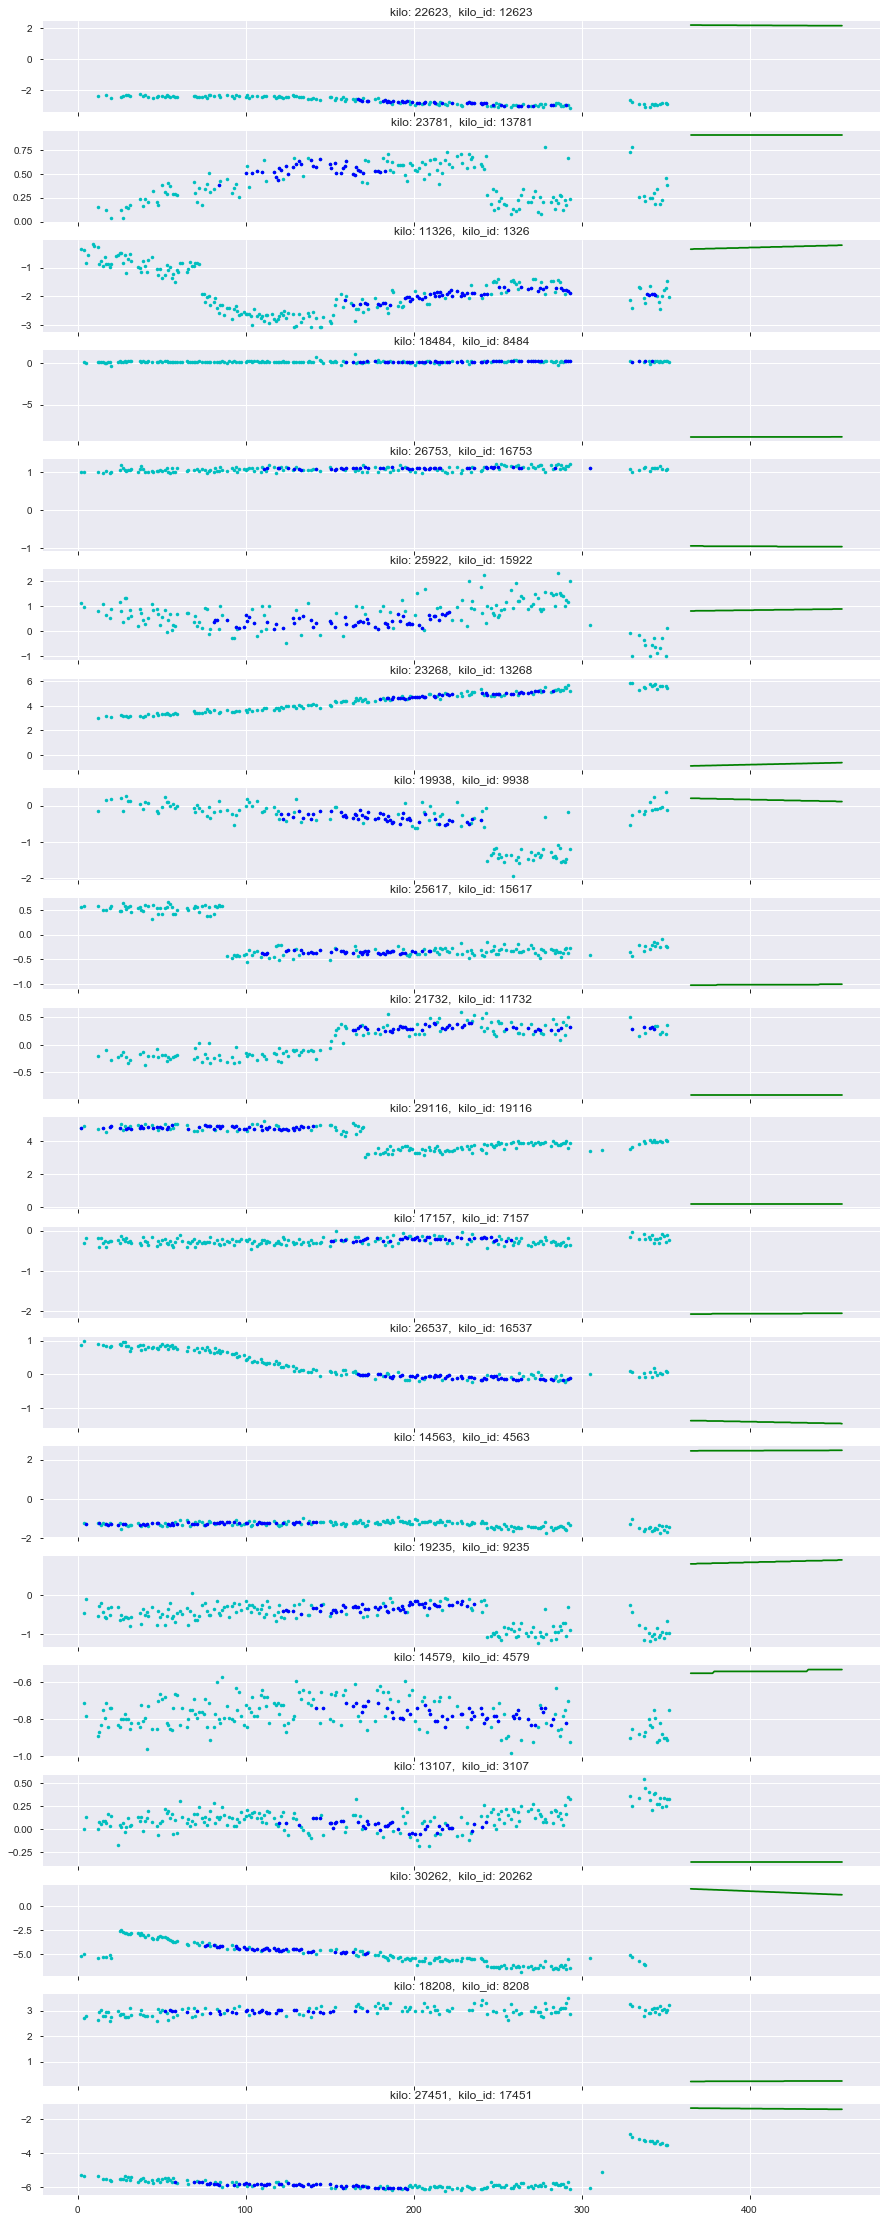

In [47]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')



    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

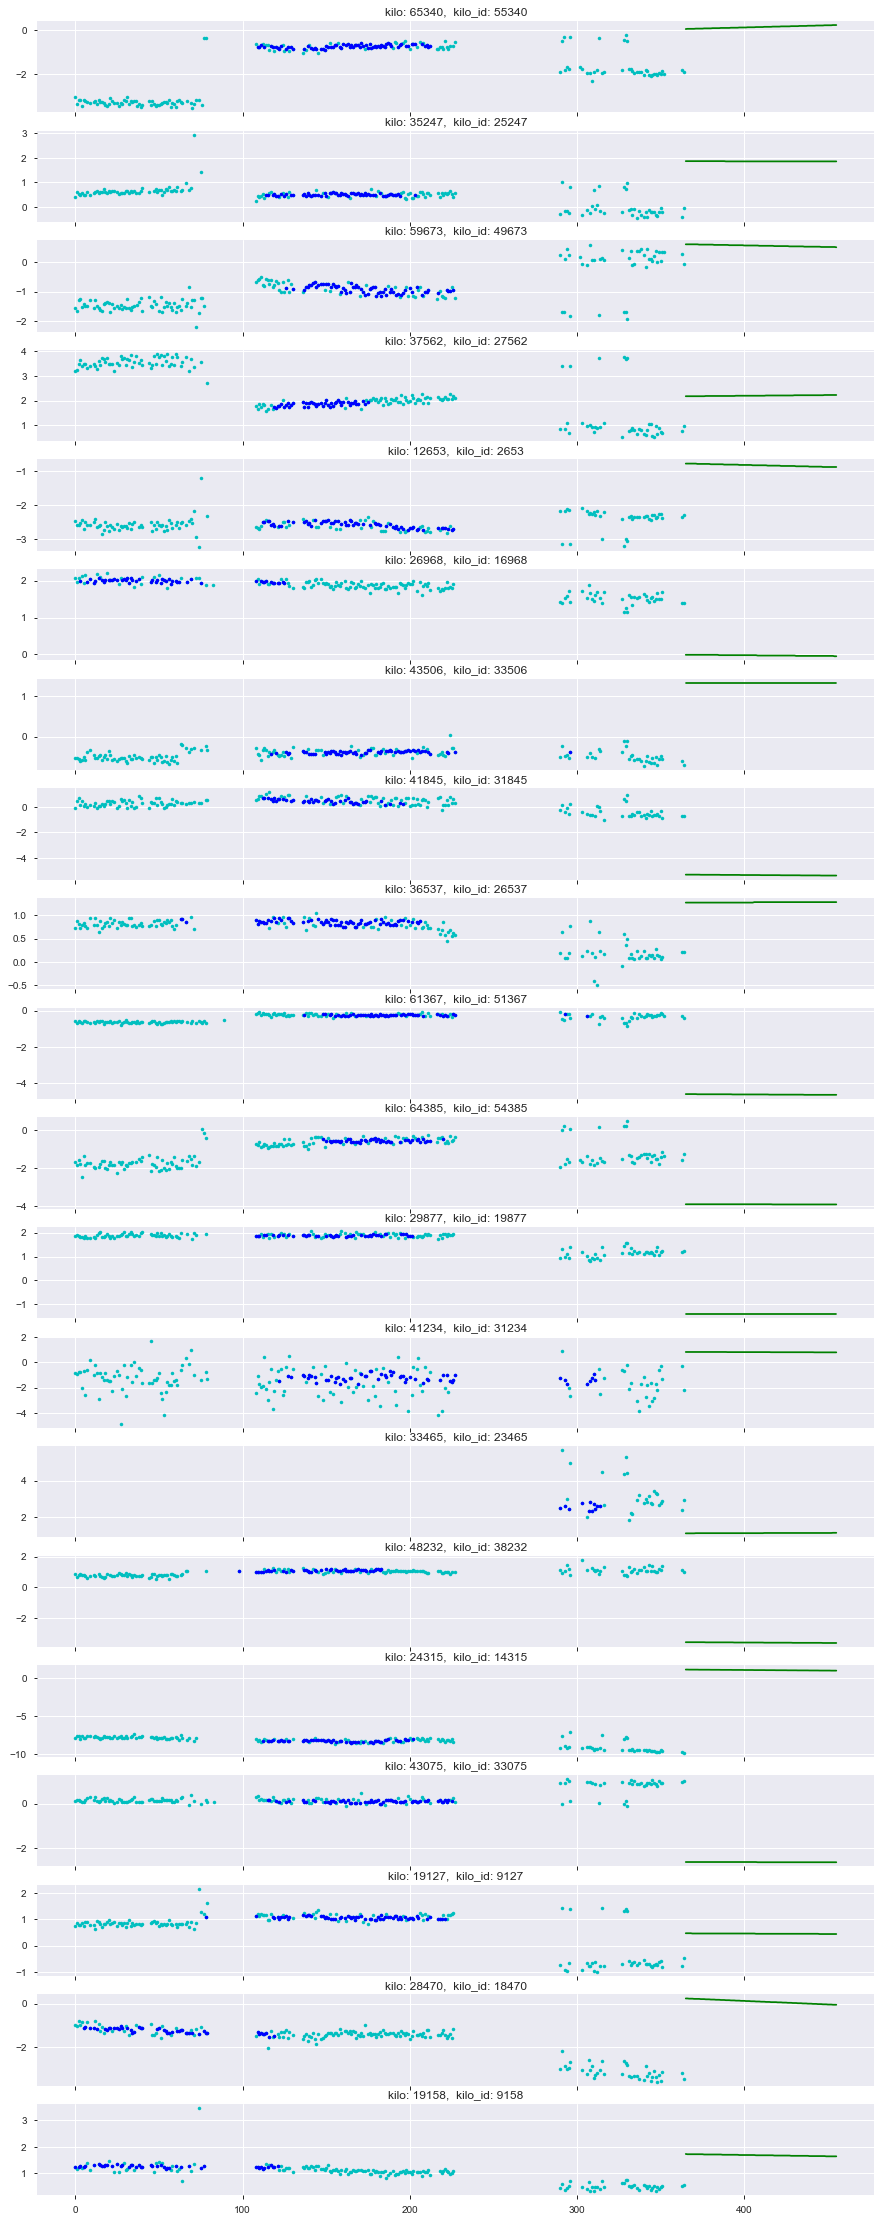

In [48]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

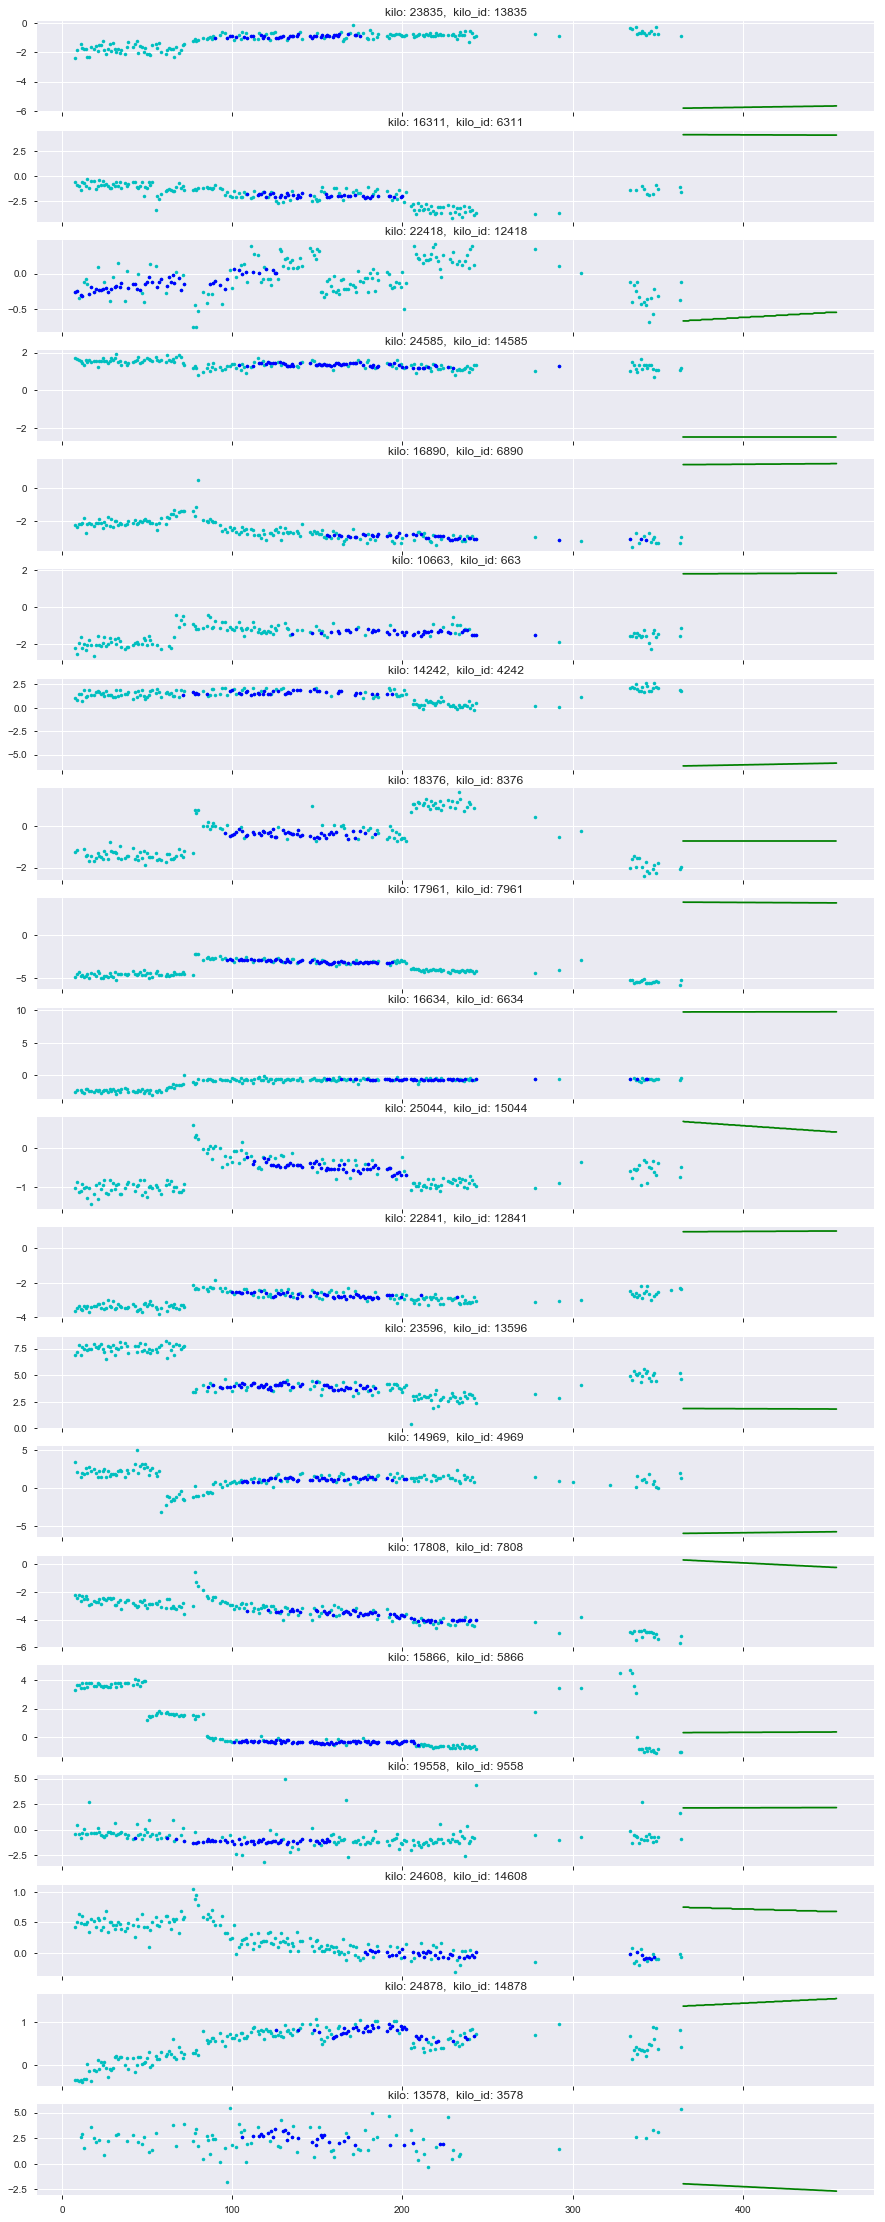

In [49]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [50]:
submision.to_csv("submit12.csv", header=None)